In [1]:
from sklearn.linear_model import LogisticRegression, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, SelectFromModel, SelectKBest, chi2, mutual_info_classif
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours, NearMiss
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.combine import SMOTETomek, SMOTEENN
from scipy.stats import chi2_contingency
import warnings
import os
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

In [2]:
train_path = os.path.join("..", "data", "input", "train_encoded.csv")
val_path = os.path.join("..", "data", "input", "val_encoded.csv")
test_path = os.path.join("..", "data", "input", "test_encoded.csv")
y_path = os.path.join("..", "data", "input", "target.csv")
# this should be the one we use
# test_path = os.path.join("..", "data", "input", "y_bin.csv")

X_train = pd.read_csv(train_path, index_col=0)
X_val = pd.read_csv(val_path, index_col=0)
test = pd.read_csv(test_path, index_col=0)
y = pd.read_csv(y_path, index_col=0)

In [3]:
X = pd.concat([X_train, X_val], axis=0)
X.head()

,race_0,race_1,race_2,race_3,gender,age_0,age_1,age_2,age_3,age_4,...,med_acetohexamide,med_metformin-rosiglitazone,med_metformin,med_troglitazone,med_miglitol,med_glipizide,med_glimepiride-pioglitazone,med_repaglinide,med_glyburide-metformin,age_mean
encounter_id,,,,,,,,,,,,,,,,,,,,,
672135,-0.632456,0.534522,-0.316228,0.119523,1.0,-0.495434,0.522233,-0.453425,0.336581,-0.214834,...,0,0,0,0,0,0,0,0,0,1.823370
794587,-0.316228,-0.267261,0.632456,-0.478091,0.0,-0.385337,0.174078,0.151142,-0.411377,0.501280,...,0,0,0,0,0,0,0,0,0,0.547373
694232,-0.632456,0.534522,-0.316228,0.119523,1.0,-0.275241,-0.087039,0.377854,-0.317882,-0.035806,...,0,0,0,0,0,0,0,0,0,1.185371
305869,-0.316228,-0.267261,0.632456,-0.478091,1.0,-0.385337,0.174078,0.151142,-0.411377,0.501280,...,0,0,0,0,0,0,0,0,0,0.547373
181753,-0.632456,0.534522,-0.316228,0.119523,0.0,-0.385337,0.174078,0.151142,-0.411377,0.501280,...,0,0,0,0,0,1,0,0,0,0.547373


In [4]:
y = y.reindex(X.index)
y.head()

,readmitted_binary
encounter_id,
672135,No
794587,No
694232,No
305869,No
181753,No


## balancing the dataset

after some research found there are three main categories to balance data, __undersampling__, __oversampling__, and a __combination__ of both.

will test all of them to decide which will be the best method to use

In [5]:
def evaluate(balancer):
    
    skf = StratifiedKFold(n_splits=10, shuffle=True)
    model = LogisticRegression(
        verbose=1,
        random_state = 42
    )
    
    score_train = []
    score_test = []
    timer = []
    f1_s = []
    
    for train_index, test_index in skf.split(X, y, ):
        # get the indexes of the observations assigned for each partition
        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]

        X_res, y_res = balancer.fit_resample(X_train, y_train)
        
        # start counting time
        begin = time.perf_counter()
        # fit the model to the data
        model.fit(X_res, y_res)
        # finish counting time
        end = time.perf_counter()
        # check the mean accuracy for the train
        value_train = model.score(X_res, y_res)
        # check the mean accuracy for the test
        value_test = model.score(X_val, y_val)
        # check the f1 score
        y_pred = model.predict(X_val)
        value_f1 = f1_score(y_val, y_pred, pos_label='Yes')
        # append the accuracies, the time and the number of iterations in the corresponding list
        score_train.append(value_train)
        score_test.append(value_test)
        timer.append(end-begin)
        f1_s.append(value_f1)
    # calculate the average and the std for each measure (accuracy, time and number of iterations)
    avg_time = round(np.mean(timer), 3)
    avg_train = round(np.mean(score_train), 3)
    avg_test = round(np.mean(score_test), 3)
    std_time = round(np.std(timer), 2)
    std_train = round(np.std(score_train), 2)
    std_test = round(np.std(score_test), 2)
    avg_f1 = round(np.mean(f1_s * 100), 6)
    std_f1 = round(np.std(f1_s * 100), 6)

    return str(avg_time) + '+/-' + str(std_time), str(avg_train) + '+/-' + str(std_train), \
        str(avg_test) + '+/-' + str(std_test), str(avg_f1) + '+/-' + str(std_f1)

def show_results(df, *args):
    for i, arg in enumerate(args):
        time, avg_train, avg_test, f1 = evaluate(arg)
        df.iloc[i] = time, avg_train, avg_test, f1
    return df

In [26]:
results_empty = pd.DataFrame(columns=['Time', 'Train', 'Test', 'f1'], index=[
                             'Tomek', 'ENN', 'NearMiss'])

results_under = show_results(results_empty,
                       TomekLinks(n_jobs=4),
                       EditedNearestNeighbours(n_neighbors=5, kind_sel='all', n_jobs=4),
                       NearMiss(n_jobs=4))

results_under

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

,Time,Train,Test,f1
Tomek,26.65+/-3.07,0.884+/-0.0,0.888+/-0.0,0.018448+/-0.005804
ENN,12.277+/-0.06,0.836+/-0.0,0.87+/-0.0,0.178855+/-0.016806
NearMiss,1.778+/-0.03,0.839+/-0.0,0.333+/-0.01,0.207924+/-0.004595


In [27]:
results_empty = pd.DataFrame(columns=['Time', 'Train', 'Test', 'f1'], index=[
                             'SMOTE', 'B-SMOTE', 'ADASYN'])

results_over = show_results(results_empty,
                       SMOTE(random_state=69),
                       BorderlineSMOTE(random_state=69),
                       ADASYN(random_state=69))

results_over

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

,Time,Train,Test,f1
SMOTE,52.505+/-3.04,0.754+/-0.0,0.729+/-0.01,0.236388+/-0.009103
B-SMOTE,56.468+/-4.54,0.759+/-0.0,0.728+/-0.0,0.243142+/-0.009321
ADASYN,53.848+/-2.01,0.751+/-0.0,0.732+/-0.01,0.232769+/-0.009269


In [31]:
results_empty = pd.DataFrame(columns=['Time', 'Train', 'Test', 'f1'], index=['SMOTEENN', 'SMOTETomek'])

results_comb = show_results(results_empty,
                       SMOTEENN(random_state=69, n_jobs=4),
                       SMOTETomek(random_state=69, n_jobs=4))

results_comb

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

,Time,Train,Test,f1
SMOTEENN,2.217+/-0.21,0.781+/-0.0,0.508+/-0.0,0.231324+/-0.005761
SMOTETomek,2.741+/-1.44,0.723+/-0.0,0.659+/-0.01,0.220391+/-0.009603


In [32]:
results_empty = pd.DataFrame(columns=['Time', 'Train', 'Test', 'f1'], index=[
                             'ENN03', 'ENN05', 'ENN07'])

results_enn = show_results(results_empty,
                       EditedNearestNeighbours(n_neighbors=3, kind_sel='all', n_jobs=4),
                       EditedNearestNeighbours(n_neighbors=5, kind_sel='all', n_jobs=4),
                       EditedNearestNeighbours(n_neighbors=7, kind_sel='all', n_jobs=4))

results_enn

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

,Time,Train,Test,f1
ENN03,0.541+/-0.02,0.856+/-0.0,0.88+/-0.0,0.127599+/-0.015625
ENN05,0.429+/-0.01,0.835+/-0.0,0.867+/-0.0,0.186579+/-0.018787
ENN07,0.34+/-0.01,0.814+/-0.0,0.846+/-0.0,0.224199+/-0.011278


In [42]:
results_empty = pd.DataFrame(columns=['Time', 'Train', 'Test', 'f1'], index=[
                             'ENNmaj', 'ENNnotmaj', 'ENN'])

results_enn = show_results(results_empty,
                       EditedNearestNeighbours(n_neighbors=5, sampling_strategy='majority' ,kind_sel='all', n_jobs=4),
                       EditedNearestNeighbours(n_neighbors=5, sampling_strategy='not majority',kind_sel='all', n_jobs=4),
                       EditedNearestNeighbours(n_neighbors=7, kind_sel='all', n_jobs=4))

results_enn

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

,Time,Train,Test,f1
ENNmaj,0.435+/-0.02,0.835+/-0.0,0.867+/-0.0,0.187795+/-0.014603
ENNnotmaj,0.56+/-0.08,1.0+/-0.0,0.888+/-0.0,0.0+/-0.0
ENN,0.343+/-0.01,0.814+/-0.0,0.846+/-0.0,0.22323+/-0.01518


ENN 07 the best option
would be nice to see how smotenk performs when we reduce the features

In [5]:
balancer = EditedNearestNeighbours(n_neighbors=7, kind_sel='all', n_jobs=4)
X_balanced, y_balanced = balancer.fit_resample(X_train, y.loc[X_train.index])

X_balanced.shape

(31151, 93)

In [6]:
rows = balancer.sample_indices_
og_indices = X_train.iloc[rows].index

X_balanced.set_index(og_indices, inplace=True)

X_balanced.head()

,race_0,race_1,race_2,race_3,gender,age_0,age_1,age_2,age_3,age_4,...,med_acetohexamide,med_metformin-rosiglitazone,med_metformin,med_troglitazone,med_miglitol,med_glipizide,med_glimepiride-pioglitazone,med_repaglinide,med_glyburide-metformin,age_mean
encounter_id,,,,,,,,,,,,,,,,,,,,,
672135,-0.632456,0.534522,-0.316228,0.119523,1.0,-0.495434,0.522233,-0.453425,0.336581,-0.214834,...,0,0,0,0,0,0,0,0,0,1.823370
181753,-0.632456,0.534522,-0.316228,0.119523,0.0,-0.385337,0.174078,0.151142,-0.411377,0.501280,...,0,0,0,0,0,1,0,0,0,0.547373
890706,-0.632456,0.534522,-0.316228,0.119523,0.0,-0.275241,-0.087039,0.377854,-0.317882,-0.035806,...,0,0,0,0,0,0,0,0,0,1.185371
648403,-0.632456,0.534522,-0.316228,0.119523,0.0,-0.055048,-0.348155,0.129550,0.336581,-0.214834,...,0,0,0,0,0,0,0,0,0,-1.366623
947413,-0.316228,-0.267261,0.632456,-0.478091,1.0,-0.055048,-0.348155,0.129550,0.336581,-0.214834,...,0,0,0,0,0,0,0,0,0,-1.366623


In [7]:
# this to compare if the rows that we have are still the same

pd.DataFrame.compare(X_balanced, X_train.iloc[rows])

encounter_id


In [8]:
y_balanced.set_index(og_indices, inplace=True)
pd.DataFrame.compare(y_balanced, y.iloc[rows])

encounter_id


In [9]:
y_new = pd.concat([y_balanced, y.loc[X_val.index]], axis=0)

In [10]:
y_new.head()

,readmitted_binary
encounter_id,
672135,No
181753,No
890706,No
648403,No
947413,No


## Feature Selection

### (former) continous variables

In [13]:
# correlation matrix for former metric features

metric_features = ['outpatient_visits_in_previous_year',
 'emergency_visits_in_previous_year',
 'inpatient_visits_in_previous_year',
 'average_pulse_bpm',
 'length_of_stay_in_hospital',
 'number_lab_tests',
 'non_lab_procedures',
 'number_of_medications',
 'number_diagnoses',
 'outpatient_visits_in_previous_year_log',
 'emergency_visits_in_previous_year_log',
 'inpatient_visits_in_previous_year_log',
 'length_of_stay_in_hospital_log',
 'non_lab_procedures_log',
 'number_of_medications_log',
 'number_diagnoses_log',
 'outpatient_visits_in_previous_year.1',
 'emergency_visits_in_previous_year.1',
 'inpatient_visits_in_previous_year.1',
 'average_pulse_bpm.1',
 'length_of_stay_in_hospital.1',
 'number_lab_tests.1',
 'non_lab_procedures.1',
 'number_of_medications.1',
 'number_diagnoses.1',
 'age_mean']

X_balanced.loc[:, metric_features]

,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,average_pulse_bpm,length_of_stay_in_hospital,number_lab_tests,non_lab_procedures,number_of_medications,number_diagnoses,outpatient_visits_in_previous_year_log,...,outpatient_visits_in_previous_year.1,emergency_visits_in_previous_year.1,inpatient_visits_in_previous_year.1,average_pulse_bpm.1,length_of_stay_in_hospital.1,number_lab_tests.1,non_lab_procedures.1,number_of_medications.1,number_diagnoses.1,age_mean
encounter_id,,,,,,,,,,,,,,,,,,,,,
672135,-0.287234,-0.220999,-0.505724,-0.287912,-0.466077,1.012943,1.558432,1.967650,0.813604,-0.442317,...,-0.360788,-0.316412,-0.543380,-0.287912,-0.466077,1.022697,1.558432,2.062442,0.823086,1.823370
181753,-0.287234,-0.220999,-0.505724,1.143652,-0.131596,-0.156700,-0.198828,-0.001983,-0.735636,-0.442317,...,-0.360788,-0.316412,-0.543380,1.143652,-0.131596,-0.154945,-0.198828,0.006539,-0.741422,0.547373
890706,2.822945,-0.220999,-0.505724,0.623083,0.202885,-1.275489,-0.198828,-0.371289,0.813604,2.263409,...,4.039547,-0.316412,-0.543380,0.623083,0.202885,-1.281386,-0.198828,-0.378943,0.823086,1.185371
648403,-0.287234,-0.220999,0.280789,-1.372431,-0.800559,-1.733176,0.972679,0.121119,0.813604,-0.442317,...,-0.360788,-0.316412,0.328783,-1.372431,-0.800559,-1.742202,0.972679,0.135033,0.823086,-1.366623
947413,-0.287234,-0.220999,-0.505724,0.970129,-0.131596,-0.004138,-0.784582,-1.109901,-1.252049,-0.442317,...,-0.360788,-0.316412,-0.543380,0.970129,-0.131596,-0.001340,-0.784582,-1.149907,-1.262924,-1.366623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320200,-0.287234,-0.220999,-0.505724,1.620840,-1.135040,-0.461824,-0.784582,-0.371289,0.813604,-0.442317,...,-0.360788,-0.316412,-0.543380,1.620840,-1.135040,-0.462156,-0.784582,-0.378943,0.823086,0.547373
440159,0.490311,0.894032,2.640328,1.664221,0.871847,-0.004138,0.386925,-0.001983,0.813604,2.259089,...,0.739296,1.585264,2.945269,1.664221,0.871847,-0.001340,0.386925,0.006539,0.823086,0.547373
371292,-0.287234,0.894032,-0.505724,-1.285670,0.871847,0.250132,1.558432,0.859731,0.813604,-0.442317,...,-0.360788,1.585264,-0.543380,-1.285670,0.871847,0.254670,1.558432,0.905996,0.823086,0.547373


In [11]:
y_balanced["readmitted_binary"] = y_balanced.replace({'Yes': 1, 'No': 0})
y_new["readmitted_binary"] = y_new.replace({'Yes': 1, 'No': 0})

y_balanced.head()

,readmitted_binary
encounter_id,
672135,0
181753,0
890706,0
648403,0
947413,0


In [50]:
X_rand = X_balanced[metric_features].sample(frac=1, axis=1)
X_val_metric = X_val[metric_features].reindex(columns=X_rand.columns)

X_r = pd.concat([X_rand, X_val_metric], axis=0)
X_r

,number_diagnoses_log,outpatient_visits_in_previous_year,non_lab_procedures.1,length_of_stay_in_hospital.1,outpatient_visits_in_previous_year.1,number_of_medications,outpatient_visits_in_previous_year_log,inpatient_visits_in_previous_year.1,length_of_stay_in_hospital_log,number_diagnoses,...,number_of_medications_log,average_pulse_bpm.1,emergency_visits_in_previous_year,number_lab_tests,number_of_medications.1,age_mean,emergency_visits_in_previous_year.1,length_of_stay_in_hospital,inpatient_visits_in_previous_year,non_lab_procedures
encounter_id,,,,,,,,,,,,,,,,,,,,,
672135,0.864232,-0.287234,1.558432,-0.466077,-0.360788,1.967650,-0.442317,-0.543380,-0.249231,0.813604,...,1.728691,-0.287912,-0.220999,1.012943,2.062442,1.823370,-0.316412,-0.466077,-0.505724,1.558432
181753,-0.911619,-0.287234,-0.198828,-0.131596,-0.360788,-0.001983,-0.442317,-0.543380,0.156037,-0.735636,...,0.162575,1.143652,-0.220999,-0.156700,0.006539,0.547373,-0.316412,-0.131596,-0.505724,-0.198828
890706,0.864232,2.822945,-0.198828,0.202885,4.039547,-0.371289,2.263409,-0.543380,0.481067,0.813604,...,-0.238750,0.623083,-0.220999,-1.275489,-0.378943,1.185371,-0.316412,0.202885,-0.505724,-0.198828
648403,0.864232,-0.287234,0.972679,-0.800559,-0.360788,0.121119,-0.442317,0.328783,-0.795123,0.813604,...,0.285226,-1.372431,-0.220999,-1.733176,0.135033,-1.366623,-0.316412,-0.800559,0.280789,0.972679
947413,-1.316606,-0.287234,-0.784582,-0.131596,-0.360788,-1.109901,-0.442317,-0.543380,0.156037,-1.252049,...,-1.279244,0.970129,-0.220999,-0.004138,-1.149907,-1.366623,-0.316412,-0.131596,-0.505724,-0.784582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181659,0.175816,-0.287234,2.729939,1.206329,-0.360788,3.444874,-0.442317,-0.543380,1.197531,0.297190,...,2.582496,-0.461435,-0.220999,1.979170,3.475876,-0.728625,-0.316412,1.206329,-0.505724,2.729939
332892,-0.415196,-0.287234,-0.784582,-0.800559,-0.360788,-0.617493,-0.442317,0.328783,-0.795123,-0.219223,...,-0.541573,0.145895,-0.220999,-0.461824,-0.635931,0.547373,-0.316412,-0.800559,0.280789,-0.784582
925848,0.864232,-0.287234,-0.784582,0.871847,-0.360788,0.859731,-0.442317,0.328783,0.989476,0.813604,...,0.936204,1.187033,-0.220999,0.656965,0.905996,-0.090626,-0.316412,0.871847,0.280789,-0.784582


In [15]:
X_val_metric

,length_of_stay_in_hospital,inpatient_visits_in_previous_year,emergency_visits_in_previous_year.1,number_lab_tests.1,number_diagnoses,number_of_medications_log,inpatient_visits_in_previous_year_log,non_lab_procedures_log,number_diagnoses_log,inpatient_visits_in_previous_year.1,...,non_lab_procedures.1,length_of_stay_in_hospital_log,outpatient_visits_in_previous_year_log,number_of_medications.1,number_diagnoses.1,age_mean,average_pulse_bpm,number_of_medications,emergency_visits_in_previous_year_log,outpatient_visits_in_previous_year.1
encounter_id,,,,,,,,,,,,,,,,,,,,,
401962,-1.135040,-0.505724,-0.316412,-0.615762,-0.735636,-0.098773,-0.714249,1.053159,-0.911619,-0.543380,...,1.558432,-1.663783,-0.442317,-0.250449,-0.741422,-1.366623,0.449560,-0.248187,-0.358029,-0.360788
617565,0.871847,-0.505724,-0.316412,0.049862,-1.252049,0.034770,-0.714249,0.912115,-1.316606,-0.543380,...,0.386925,0.989476,-0.442317,-0.121955,-1.262924,0.547373,-1.112147,-0.125085,-0.358029,-0.360788
356044,-0.466077,0.280789,-0.316412,0.561881,-1.252049,-0.541573,1.377089,-1.082689,-1.316606,0.328783,...,-0.784582,-0.249231,-0.442317,-0.635931,-1.262924,0.547373,-1.589335,-0.617493,-0.358029,-0.360788
486082,-1.135040,-0.505724,1.585264,-0.666964,-0.735636,0.162575,-0.714249,-1.082689,-0.911619,-0.543380,...,-0.784582,-1.663783,2.259089,0.006539,-0.741422,-0.090626,-1.459193,-0.001983,2.792968,0.739296
665939,2.209772,1.853815,-0.316412,0.869092,0.813604,-0.386005,1.433731,0.774469,0.864232,2.073107,...,-0.198828,1.708639,-0.442317,-0.507437,0.823086,0.547373,1.664221,-0.494391,-0.358029,-0.360788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181659,1.206329,-0.505724,-0.316412,1.995532,0.297190,2.582496,-0.714249,1.137273,0.175816,-0.543380,...,2.729939,1.197531,-0.442317,3.475876,0.301584,-0.728625,-0.461435,3.444874,-0.358029,-0.360788
332892,-0.800559,0.280789,-0.316412,-0.462156,-0.219223,-0.541573,1.377089,-1.082689,-0.415196,0.328783,...,-0.784582,-0.795123,-0.442317,-0.635931,-0.219919,0.547373,0.145895,-0.617493,-0.358029,-0.360788
925848,0.871847,0.280789,-0.316412,0.664284,0.813604,0.936204,1.377089,-1.082689,0.864232,0.328783,...,-0.784582,0.989476,-0.442317,0.905996,0.823086,-0.090626,1.187033,0.859731,-0.358029,-0.360788


In [16]:
X_rand = X_balanced[metric_features].sample(frac=1, axis=1)
X_val_metric = X_val[metric_features].reindex(columns=X_rand.columns)

nof_list = np.arange(1, len(X_rand.columns) + 1)
high_score = 0
# Variable to store the optimum features
nof = 0
train_score_list = []
val_score_list = []

for n in range(len(nof_list)):
    model = LogisticRegression(random_state=69, verbose=1)

    rfe = RFE(estimator=model, n_features_to_select=nof_list[n])
    X_train_rfe = rfe.fit_transform(X_rand, y_balanced)
    X_val_rfe = rfe.transform(X_val_metric)
    model.fit(X_train_rfe, y_balanced)
    
    # Storing results on training data
    y_train_pred = model.predict(X_train_rfe)
    train_score = f1_score(y_balanced, y_train_pred)
    train_score_list.append(train_score)
    
    # Storing results on validation data
    y_val_pred = model.predict(X_val_rfe)
    val_score = f1_score(y_new.loc[X_val.index], y_val_pred)
    val_score_list.append(val_score)
    
    # Check best score
    if val_score >= high_score:
        high_score = val_score
        nof = nof_list[n]

print("Optimum number of features: %d" % nof)
print("Score with %d features: %f" % (nof, high_score))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

Optimum number of features: 14
Score with 14 features: 0.189869


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


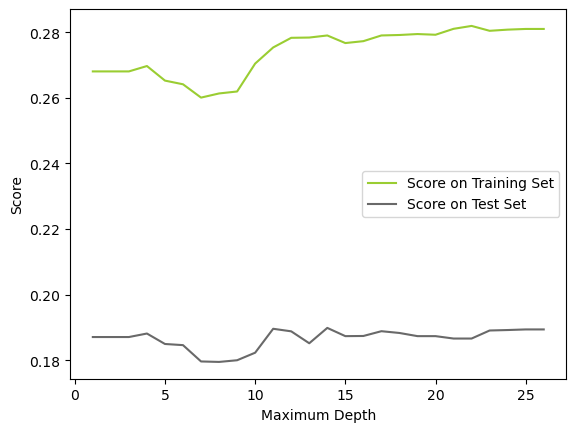

In [17]:
plt.plot(list(range(1,len(X_rand.columns)+1)), train_score_list, label="Score on Training Set", color='yellowgreen')
plt.plot(list(range(1,len(X_rand.columns)+1)), val_score_list, label="Score on Test Set", color='dimgray')
plt.xlabel("Maximum Depth")
plt.ylabel("Score")
plt.legend()
plt.show()

In [51]:
model = LogisticRegression()
rfe = RFE(estimator = model, n_features_to_select = 14)
rfe.fit_transform(X = X_rand, y = y_balanced)

array([[ 0.86423168,  1.55843243, -0.54337965, ...,  1.82336978,
        -0.31641216, -0.50572398],
       [-0.91161858, -0.1988281 , -0.54337965, ...,  0.54737254,
        -0.31641216, -0.50572398],
       [ 0.86423168, -0.1988281 , -0.54337965, ...,  1.18537116,
        -0.31641216, -0.50572398],
       ...,
       [ 0.86423168,  1.55843243, -0.54337965, ...,  0.54737254,
         1.58526429, -0.50572398],
       [-0.91161858, -0.1988281 ,  4.68959368, ...,  0.54737254,
        -0.31641216,  4.21335442],
       [ 0.86423168,  0.38692541, -0.54337965, ...,  1.18537116,
        -0.31641216, -0.50572398]])

In [52]:
coef = rfe.estimator_.coef_
ranking = rfe.ranking_
ranking

array([ 1,  4,  1,  2,  6, 11,  3,  1,  1,  1,  1,  8,  1,  1, 12, 10,  1,
       13,  5,  1,  1,  1,  1,  9,  1,  7])

In [85]:
selected_features = pd.Series(rfe.support_, index = X_rand.columns)
names = np.array(selected_features[selected_features.values == True].index)
names
selected_features.sort_index()

age_mean                                   True
average_pulse_bpm                         False
average_pulse_bpm.1                       False
emergency_visits_in_previous_year         False
emergency_visits_in_previous_year.1        True
emergency_visits_in_previous_year_log     False
inpatient_visits_in_previous_year          True
inpatient_visits_in_previous_year.1        True
inpatient_visits_in_previous_year_log      True
length_of_stay_in_hospital                False
length_of_stay_in_hospital.1              False
length_of_stay_in_hospital_log             True
non_lab_procedures                        False
non_lab_procedures.1                       True
non_lab_procedures_log                    False
number_diagnoses                           True
number_diagnoses.1                         True
number_diagnoses_log                       True
number_lab_tests                           True
number_lab_tests.1                         True
number_of_medications                   

In [54]:
pd.DataFrame({'coef': coef.reshape(-1)}, index=names).sort_index()

,coef
age_mean,0.123511
emergency_visits_in_previous_year.1,0.139906
inpatient_visits_in_previous_year,0.526816
inpatient_visits_in_previous_year.1,0.167016
inpatient_visits_in_previous_year_log,0.093590
length_of_stay_in_hospital_log,0.162066
non_lab_procedures.1,-0.078913
number_diagnoses,0.687874
number_diagnoses.1,-0.378172
number_diagnoses_log,-0.155971


In [48]:
metric_to_keep = ['age_mean',
       'non_lab_procedures.1',
       'inpatient_visits_in_previous_year.1',
       'emergency_visits_in_previous_year.1', 'number_diagnoses',
       'number_of_medications_log', 'length_of_stay_in_hospital_log', 'number_lab_tests']

len(metric_to_keep)

8

In [86]:
lasso_cv = ElasticNetCV(cv=10)
lasso_cv.fit(X_rand, y_balanced)
feature_names = X_rand.columns
coefficients = lasso_cv.coef_

lasso_metric = pd.DataFrame(data=coefficients, index=feature_names, columns=['Coefficient'])
lasso_metric = lasso_metric[lasso_metric['Coefficient'].abs() > 0.001]
lasso_metric.sort_index()

,Coefficient
age_mean,0.016066
average_pulse_bpm,-0.001430
emergency_visits_in_previous_year,0.004265
emergency_visits_in_previous_year.1,0.017361
emergency_visits_in_previous_year_log,0.002454
inpatient_visits_in_previous_year,0.007794
inpatient_visits_in_previous_year.1,0.133328
length_of_stay_in_hospital_log,0.023053
non_lab_procedures,-0.002181
non_lab_procedures.1,-0.011448


In [192]:
lasso_to_keep = ['age_mean', 'average_pulse_bpm',
       'emergency_visits_in_previous_year.1',
       'inpatient_visits_in_previous_year.1',
       'length_of_stay_in_hospital_log', 'non_lab_procedures',
       'number_diagnoses_log', 'number_lab_tests.1',
       'number_of_medications_log', 'outpatient_visits_in_previous_year']

In [57]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=69, max_features='sqrt', max_samples=0.6)

In [73]:
importances = rf_classifier.fit(X_rand, y_balanced).feature_importances_

In [74]:
all_importance = pd.DataFrame(importances, columns=['importance'], index = X_r.columns).sort_values(by='importance', ascending=False)
all_importance['agg_sum'] = all_importance['importance'].cumsum()
all_importance = all_importance[all_importance['agg_sum'] <= 0.8]
all_importance


,importance,agg_sum
average_pulse_bpm.1,0.090206,0.090206
average_pulse_bpm,0.089500,0.179706
number_lab_tests,0.089184,0.268890
number_lab_tests.1,0.087548,0.356438
number_of_medications,0.056733,0.413171
number_of_medications_log,0.055885,0.469057
number_of_medications.1,0.054920,0.523976
age_mean,0.053538,0.577514
inpatient_visits_in_previous_year.1,0.041949,0.619463
inpatient_visits_in_previous_year,0.037475,0.656937


In [64]:
rf_keep = ['average_pulse_bpm.1', 'number_lab_tests', 'number_of_medications', 'age_mean',
       'length_of_stay_in_hospital', 'inpatient_visits_in_previous_year.1', 'non_lab_procedures']

### formar categorical variables

In [75]:
cat_features = [x for x in X_balanced.columns if x not in metric_features]

In [76]:
X_rand_c = X_balanced[cat_features].sample(frac=1, axis=1)
X_val_cat = X_val[cat_features].reindex(columns=X_rand.columns)

X_c = pd.concat([X_rand_c, X_val_cat], axis=0)
X_c

,payer_code,age_8,age_4,discharge_disposition_cat_1,change_in_meds_during_hospitalization,med_miglitol,age_7,age_6,med_glimepiride,med_rosiglitazone,...,number_of_medications_log,average_pulse_bpm.1,emergency_visits_in_previous_year,number_lab_tests,number_of_medications.1,age_mean,emergency_visits_in_previous_year.1,length_of_stay_in_hospital,inpatient_visits_in_previous_year,non_lab_procedures
encounter_id,,,,,,,,,,,,,,,,,,,,,
672135,0.119583,-0.004535,-0.214834,0.534522,0.0,0.0,0.018699,-0.052694,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
181753,0.125554,0.040816,0.501280,-0.534522,0.0,0.0,-0.130893,0.275179,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
890706,0.122358,-0.163266,-0.035806,-0.267261,0.0,0.0,0.373979,-0.503518,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
648403,0.125219,-0.571430,-0.214834,-0.267261,1.0,0.0,0.261785,0.327872,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
947413,0.087872,-0.571430,-0.214834,-0.267261,1.0,0.0,0.261785,0.327872,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
332892,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
925848,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
def TestIndependence(X,y,var,alpha=0.05):        
    dfObserved = pd.crosstab(y,X) 
    chi2, p, dof, expected = chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result="{0} is IMPORTANT for Prediction".format(var)
    else:
        result="{0} is NOT an important predictor. (Discard {0} from model)".format(var)
    print(result)

In [68]:
for var in X_balanced[cat_features]:
    TestIndependence(X_balanced[var], y_balanced['readmitted_binary'], var)

race_0 is IMPORTANT for Prediction
race_1 is NOT an important predictor. (Discard race_1 from model)
race_2 is IMPORTANT for Prediction
race_3 is IMPORTANT for Prediction
gender is IMPORTANT for Prediction
age_0 is IMPORTANT for Prediction
age_1 is IMPORTANT for Prediction
age_2 is IMPORTANT for Prediction
age_3 is IMPORTANT for Prediction
age_4 is IMPORTANT for Prediction
age_5 is IMPORTANT for Prediction
age_6 is IMPORTANT for Prediction
age_7 is IMPORTANT for Prediction
age_8 is IMPORTANT for Prediction
payer_code is NOT an important predictor. (Discard payer_code from model)
admission_type_0 is IMPORTANT for Prediction
admission_type_1 is IMPORTANT for Prediction
admission_type_2 is IMPORTANT for Prediction
admission_type_3 is IMPORTANT for Prediction
admission_type_4 is IMPORTANT for Prediction
discharge_disposition is IMPORTANT for Prediction
admission_source is NOT an important predictor. (Discard admission_source from model)
glucose_test_result_0 is IMPORTANT for Prediction
glu

In [69]:
# chi2_selector = SelectKBest(chi2, k='all')
# X_chi2 = chi2_selector.fit_transform(X_balanced[cat_features], y_balanced)

mutual_info_selector = SelectKBest(mutual_info_classif, k='all')
X_mutual_info = mutual_info_selector.fit_transform(X_balanced.sample(frac=1, axis=1)[cat_features], y_balanced)

In [77]:
param_grid = {'k': [10, 20, 30, 40, 50, 'all']}  # Adjust the range as needed

# Create the mutual info selector
mutual_info_selector = SelectKBest(mutual_info_classif)
grid_search = GridSearchCV(mutual_info_selector, param_grid, scoring='f1', cv=5)

# Fit the grid search on the training data
grid_search.fit(X_rand_c, y_balanced)

# Get the best value of k from the grid search
best_k = grid_search.best_params_['k']

# Refit the selector with the best k value on the full training set
mutual_info_selector = SelectKBest(mutual_info_classif, k=best_k)
X_mutual_info = mutual_info_selector.fit_transform(X_rand_c, y_balanced)

In [78]:
best_k

10

In [79]:
mutual_info_selector.get_support(indices=True)

array([ 3, 10, 11, 30, 32, 37, 42, 52, 53, 62], dtype=int64)

In [88]:
X_rand_c[cat_features].iloc[:, [ 3, 10, 11, 30, 32, 37, 42, 52, 53, 62]].columns

Index(['race_3', 'age_5', 'age_6', 'is_outpatient_visited',
       'is_inpatient_visited', 'discharge_disposition_cat_0',
       'admission_source_cat_1', 'med_glipizide-metformin', 'med_glyburide',
       'med_miglitol'],
      dtype='object')

In [81]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=69, max_features='sqrt', max_samples=0.6)
cat_importance = rf_classifier.fit(X_rand_c, y_balanced).feature_importances_
all_importance = pd.DataFrame(cat_importance, columns=['importance'], index = X_rand_c.columns).sort_values(by='importance', ascending=False)
all_importance['agg_sum'] = all_importance['importance'].cumsum()
all_importance = all_importance[all_importance['agg_sum'] <= 0.8]
all_importance

,importance,agg_sum
discharge_disposition,0.100720,0.100720
additional_diagnosis_cat,0.087334,0.188053
primary_diagnosis_cat,0.087295,0.275349
secondary_diagnosis_cat,0.086502,0.361851
payer_code,0.084418,0.446269
admission_source,0.083897,0.530166
is_inpatient_visited,0.059768,0.589933
is_pulse_normal,0.017099,0.607032
gender,0.016494,0.623527
is_emergency_visited,0.014860,0.638386


In [89]:
all_importance.index

Index(['discharge_disposition', 'additional_diagnosis_cat',
       'primary_diagnosis_cat', 'secondary_diagnosis_cat', 'payer_code',
       'admission_source', 'is_inpatient_visited', 'is_pulse_normal', 'gender',
       'is_emergency_visited', 'change_in_meds_during_hospitalization',
       'med_insulin', 'is_outpatient_visited', 'a1c_test_result_2',
       'a1c_test_result_0', 'med_metformin', 'age_2', 'admission_type_4',
       'age_4', 'age_8', 'discharge_disposition_cat_0', 'age_0',
       'admission_type_2', 'age_6', 'race_0'],
      dtype='object')

now decide which are the best from the selection criteria :)

| Feature                            | RFE_LR  | Lasso   | RFC     | Final_Decision |
|:-----------------------------------|:--------|:--------|:--------|:---------------|
| age_mean                           | keep    | keep | keep | keep        |
| outpatient                         | discard    | keep | discard | discard        |
| outpatient_log                     | discard    | keep | discard | discard        |
| outpatient_win                     | discard    | keep | discard | discard        |
| emergency                          | discard    | keep    | discard    | discard           |
| emergency_log                      | discard    | keep    | discard    | discard           |
| emergency_win                      | keep    | keep    | discard    | keep           |
| inpatient                          | keep    | keep    | keep    | keep           |
| inpatient_log                      | keep    | discard    | keep    | keep           |
| inpatient_win                      | keep    | keep    | keep    | keep           |
| average_pulse_bpm                  | discard    | keep | keep | keep        |
| average_pulse_bpm_win              | discard    | discard | keep | discard        |
| length_of_stay                    | discard    | discard    | keep    | discard           |
| length_of_stay_log                | keep    | keep    | keep    | keep           |
| length_of_stay_win                | discard    | discard    | keep    | keep           |
| number_lab_tests                   | keep    | discard | keep | keep        |
| number_lab_tests_win                   | keep    | keep | keep | keep        |
| non_lab_procedures                 | discard    | keep    | discard | discard           |
| non_lab_procedures_log                 | discard    | keep    | discard | discard           |
| non_lab_procedures_win                 | keep    | keep    | discard | keep           |
| number_of_medications              | discard    | discard    | keep    | discard           |
| number_of_medications_log              | keep    | keep    | keep    | keep           |
| number_of_medications_win              | keep    | keep    | keep    | keep           |
| number_diagnoses                   | keep    | keep    | discard    | keep           |
| number_diagnoses_log                   | keep    | keep    | discard    | keep           |
| number_diagnoses_win                   | keep    | discard    | discard    | discard           |

| Feature                                | chi2   | mutual | RFC   | Final_Decision |
|:---------------------------------------|:-------|:-------|:-----|:---------------|
| race_0                                 | keep   | keep   | keep | keep           |
| race_1                                 | discard| discard| discard | discard      |
| race_2                                 | keep   | discard| discard | discard      |
| race_3                                 | keep   | keep   | discard | keep      |
| gender                                 | keep   | discard| keep | keep       |
| age_0                                  | keep   | discard| keep | keep       |
| age_1                                  | keep   | discard| discard | discard      |
| age_2                                  | keep   | discard| keep | keep          |
| age_3                                  | keep   | discard| discard | discard      |
| age_4                                  | keep   | discard| keep | keep          |
| age_5                                  | keep   | keep   | discard | keep      |
| age_6                                  | keep   | keep   | keep | keep           |
| age_7                                  | keep   | discard| discard | discard      |
| age_8                                  | keep   | discard| keep | keep          |
| admission_type_0                      | keep   | discard| discard | discard      |
| admission_type_1                      | keep   | discard| discard | discard      |
| admission_type_2                      | keep   | discard| discard | discard      |
| admission_type_3                      | keep   | discard| discard | discard      |
| admission_type_4                      | keep   | discard| keep | keep          |
| discharge_disposition                 | keep   | discard| keep | keep          |
| payer_code                             | discard| discard| keep | discard       |
| admission_source                       | discard| discard| keep | discard       |
| glucose_test_result_0                 | keep   | discard| discard | discard      |
| glucose_test_result_1                 | keep   | discard| discard | discard      |
| glucose_test_result_2                 | keep   | discard| discard | discard      |
| a1c_test_result_0                     | keep   | discard| discard | discard      |
| a1c_test_result_1                     | keep   | discard| discard | discard      |
| a1c_test_result_2                     | keep   | discard| keep | keep          |
| change_in_meds_during_hospitalization | keep   | discard| keep | keep       |
| prescribed_diabetes_meds              | keep   | discard| discard | discard      |
| is_outpatient_visited                 | keep   | keep   | keep | keep           |
| is_emergency_visited                   | keep  | discard| keep | keep       |
| is_inpatient_visited                   | keep  | keep   | keep | keep           |
| is_pulse_normal                       | discard| discard| discard | discard      |
| primary_diagnosis_cat                  | discard| discard| keep | discard       |
| secondary_diagnosis_cat                | discard| discard| keep | discard       |
| additional_diagnosis_cat               | discard| discard| keep | discard       |
| discharge_disposition_cat_0           | keep  | discard| keep | keep       |
| discharge_disposition_cat_1           | keep  | discard| discard | discard      |
| discharge_disposition_cat_2           | keep  | discard| discard | discard      |
| discharge_disposition_cat_3           | keep  | discard| discard | discard      |
| admission_source_cat_0                | keep  | discard| keep | keep       |
| admission_source_cat_1                | keep  | keep   | discard | keep      |
| admission_source_cat_2                | keep  | discard| discard | discard      |
| admission_source_cat_3                | keep  | discard| keep | keep       |
| admission_source_cat_4                | keep  | discard| discard | discard      |
| med_metformin-pioglitazone            | discard| discard| discard | discard      |
| med_glimepiride                       | keep  | discard| keep | keep          |
| med_nateglinide                       | discard| discard| discard | discard      |
| med_rosiglitazone                     | discard| discard| discard | discard      |
| med_tolbutamide                       | discard| discard| discard | discard      |
| med_tolazamide                         | discard| discard| discard | discard      |
| med_glipizide-metformin               | discard| keep   | discard | discard      |
| med_glyburide                         | discard| keep   | discard | discard      |
| med_acarbose                           | discard| discard| discard | discard      |
| med_insulin                           | keep  | discard| keep | keep          |
| med_pioglitazone                       | discard| discard| discard | discard      |
| med_chlorpropamide                     | discard| discard| discard | discard      |
| med_acetohexamide                      | discard| discard| discard | discard      |
| med_metformin-rosiglitazone            | discard| discard| discard | discard      |
| med_metformin                         | keep  | discard| keep | keep          |
| med_troglitazone                       | discard| discard| discard | discard      |
| med_miglitol                           | discard| keep   | discard | discard      |
| med_glipizide                         | discard| discard| discard | discard      |
| med_glimepiride-pioglitazone          | discard| discard| discard | discard      |
| med_repaglinide                       | keep  | discard| keep | keep          |
| med_glyburide-metformin               | discard| discard| discard | discard      |


In [95]:
metric_keep = ['age_mean',
       'non_lab_procedures.1',
       'inpatient_visits_in_previous_year.1',
       'average_pulse_bpm',
       'emergency_visits_in_previous_year.1',
       'number_diagnoses',
       'number_of_medications_log',
       'length_of_stay_in_hospital_log',
       'number_lab_tests.1',
    ]

removed duplicates according to ranking and to the coeficients, in order to avoid collinearity in the features.

In [96]:
cat_keep = [
    "race_0",
    "race_3",
    "gender",
    "age_0",
    "age_2",
    "age_4",
    "age_5",
    "age_6",
    "age_8",
    "admission_type_4",
    "discharge_disposition",
    "a1c_test_result_2",
    "change_in_meds_during_hospitalization",
    "is_outpatient_visited",
    "is_emergency_visited",
    "is_inpatient_visited",
    "discharge_disposition_cat_0",
    "admission_source_cat_0",
    "admission_source_cat_1",
    "admission_source_cat_3",
    "med_glimepiride",
    "med_insulin",
    "med_repaglinide",
    "med_metformin",
]

In [97]:
features_to_keep = metric_keep + cat_keep
features_to_keep

['age_mean',
 'non_lab_procedures.1',
 'inpatient_visits_in_previous_year.1',
 'average_pulse_bpm',
 'emergency_visits_in_previous_year.1',
 'number_diagnoses',
 'number_of_medications_log',
 'length_of_stay_in_hospital_log',
 'number_lab_tests.1',
 'race_0',
 'race_3',
 'gender',
 'age_0',
 'age_2',
 'age_4',
 'age_5',
 'age_6',
 'age_8',
 'admission_type_4',
 'discharge_disposition',
 'a1c_test_result_2',
 'change_in_meds_during_hospitalization',
 'is_outpatient_visited',
 'is_emergency_visited',
 'is_inpatient_visited',
 'discharge_disposition_cat_0',
 'admission_source_cat_0',
 'admission_source_cat_1',
 'admission_source_cat_3',
 'med_glimepiride',
 'med_insulin',
 'med_repaglinide',
 'med_metformin']

In [99]:
X_train_final = X_balanced[features_to_keep]
X_val_final = X_val[features_to_keep]
test_final = test[features_to_keep]

In [100]:
X_train_final.to_csv("../data/input/train_final.csv")
X_val_final.to_csv("../data/input/val_final.csv")
test_final.to_csv("../data/input/test_final.csv")

In [19]:
y_new.to_csv("../data/input/y_bin.csv")